## In the basic_compositing and advanced_compositing notebooks we describe how to produce composites of variables with respect to categorical events.

## In this notebook we show how such composites, or any other spatial field, can be masked, filtered and reduced to a scalar activity index using the IndexGenerator class

In [13]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from domino.core import LaggedAnalyser,PatternFilter,IndexGenerator


In [61]:
IVT=xr.open_dataarray('data/IVT.nc').load()


from domino.util import offset_time_dim
UAtl=offset_time_dim(xr.open_dataarray(
    '/data/ox5324/compute_2021_clean_data/Atl_lonmean_U_1979-2021.nc'
    ).load(),-12,'hours')
UAtl=UAtl.sel(lat=IVT.lat)
UAtl=UAtl.assign_coords(plev=UAtl.plev/100)

In [41]:
event=xr.open_dataarray('data/NorthItalian_SON_90Percentile_5dPrecip.nc')

In [62]:
analyser=LaggedAnalyser(event=event,variables=dict(IVTmag=IVT,VerticalU=UAtl))

In [69]:
C=analyser.compute_composites(as_anomaly=True)

In [84]:
S=analyser.bootstrap_significance(100,p=0.1)

In [85]:
masked_C=C.where(S==1)

Text(0.5, 1.0, 'Atl zonal wind speed anomaly during event')

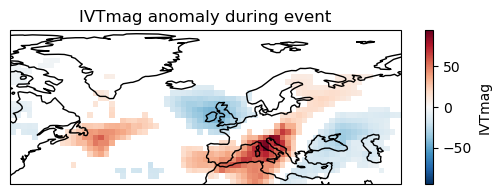

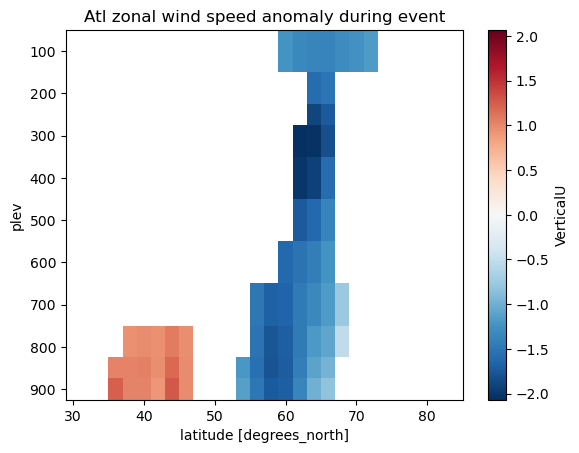

In [86]:
p=masked_C.IVTmag.sel(lag=0,index_val=1).plot(\
    transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()})
p.axes.set_title('IVTmag anomaly during event')
p.axes.coastlines()
p.figure.set_figheight(2)
plt.figure()


p=(masked_C.VerticalU).sel(index_val=1,lag=0).plot()
p.axes.invert_yaxis()
p.axes.set_title('Atl zonal wind speed anomaly during event')

In [105]:
PF=PatternFilter(analyser=analyser)

In [106]:
thresh_dict=dict(IVTmag=50,VerticalU=0.5)

def abs_amplitude_over_threshold(val_ds,thresh_dict):
    return abs(val_ds)>xr.Dataset(thresh_dict)

PF.apply_value_mask(abs_amplitude_over_threshold,thresh_dict,mode='intersection')
mask1=PF.get_mask()

In [112]:
PF.apply_area_mask(20,area_type='gridpoint',mode='intersection')

TypeError: object of type 'NoneType' has no len()

In [109]:
PF.mask_ds

<xarray.Dataset>
Dimensions:    (lon: 71, lat: 28, plev: 11, lag: 1, index_val: 2)
Coordinates:
  * lon        (lon) float32 -80.0 -78.0 -76.0 -74.0 ... 54.0 56.0 58.0 60.0
  * lat        (lat) float32 30.0 32.0 34.0 36.0 38.0 ... 78.0 80.0 82.0 84.0
  * plev       (plev) float64 100.0 200.0 250.0 300.0 ... 800.0 850.0 900.0
  * lag        (lag) int64 0
  * index_val  (index_val) int64 0 1
Data variables:
    IVTmag     (lag, index_val, lat, lon) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    VerticalU  (lag, index_val, plev, lat) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

In [97]:
PF.apply_convolution?

Signature: PF.apply_convolution(n, dims, mode='replace')
Docstring:
Apply a square n-point convolution filter to *PatternFilter.mask_ds* in one or two dimensions specified by *dims*, iterated over remaining dimensions. This has the effect of extending the unmasked regions and smoothing the mask overall.

**Arguments**
    *n*
    A positive integer specifying the size of the convolution filter. *n*=1 leaves the mask unchanged. Even *n* are asymmetric and shifted right. 
    
    *dims*
    A length 1 or 2 iterable of strings specifying the dims in which the convolution is applied. Other dims will be iterated over. DataArrays within *PatternFilter.mask_ds* that do not contain all the *dims* will be ignored. 
    
    *mode*
    A string, one of 'replace','intersection' or 'union', defining how the area filter should be used to update the *PatternFilter.mask_ds*.
File:      ~/miniconda3/lib/python3.9/site-packages/domino/core.py
Type:      method
